In [1]:
import torch
import matplotlib.pyplot as plt

torch.random.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)   

cpu


Read the CSV, and print the header and first 5 rows

In [11]:
import pandas as pd
pd.read_csv('../data/HAM2000/metadata.csv')

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0006518,ISIC_0027618,nv,follow_up,35.0,male,back
1,HAM_0004666,ISIC_0029165,nv,follow_up,55.0,male,upper extremity
2,HAM_0006455,ISIC_0029690,nv,follow_up,50.0,male,lower extremity
3,HAM_0003653,ISIC_0030139,nv,histo,45.0,male,back
4,HAM_0001330,ISIC_0026818,nv,histo,20.0,female,abdomen
...,...,...,...,...,...,...,...
1995,HAM_0000933,ISIC_0024358,bkl,histo,60.0,female,back
1996,HAM_0004673,ISIC_0029418,bkl,histo,50.0,male,back
1997,HAM_0000983,ISIC_0033490,bkl,consensus,NaN,unknown,unknown
1998,HAM_0004494,ISIC_0031459,bkl,histo,60.0,female,neck


In [35]:
import torchvision
my_resize = torchvision.transforms.Resize( (128,128) )
to_tensor_transfo = torchvision.transforms.ToTensor()
fliph = torchvision.transforms.RandomHorizontalFlip()
flipv = torchvision.transforms.RandomVerticalFlip()

my_full_transfo = torchvision.transforms.Compose(
    [
        my_resize,
        fliph,
        flipv,
        to_tensor_transfo
    ]
)

data = torchvision.datasets.ImageFolder(root="../data/HAM2000/", transform=my_full_transfo)
class_names = data.find_classes("../data/HAM2000/")[0]

data[0][0].shape

torch.Size([3, 128, 128])

In [41]:
train_size = int(0.8 * len(data))
test_size = len(data)-train_size

train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])
len(train_data), len(test_data)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

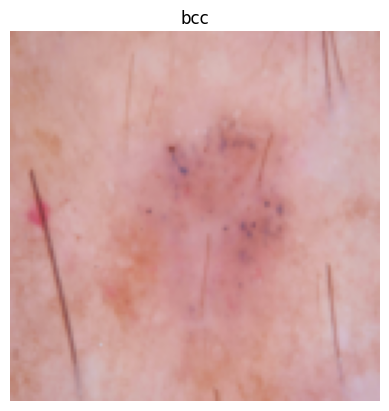

In [48]:
image, label = data[0]
plt.imshow(image.permute([1,2,0]))
plt.title(class_names[label])
plt.axis('off')
plt.show()

define the neural networ (torch.nn.module child class)

In [91]:
class MyNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = torch.nn.Linear(128*128*3, 512)
        self.dense2 = torch.nn.Linear(512, 128)
        self.dense3 = torch.nn.Linear(128, 4)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim = -1)

    def forward(self, x):
        # print(x.shape)
        x = x.view(-1, 3*128*128)
        # print(x.shape)
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.softmax(self.dense3(x))
        return x

In [94]:
model = MyNet().to(device)
model(torch.zeros( (3,128,128), device=device ))

opt = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.NLLLoss()

num_epoch = 20
losses = []
accuracies = [0.25]

In [ ]:
for epoch in range(1, num_epoch+1):
    running_loss = 0.0
    correct_class = 0
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
        num_outputs = outputs.argmax(axis=1)
        correct_class += (num_outputs==labels).sum().item()
    accuracy_epoch = correct_class/len(train_data)
    accuracies.append(accuracy_epoch)
    losses.append(running_loss)
    print(f'Epoch [{epoch}/{num_epoch}]: Acc={accuracy_epoch:.4f} Loss={running_loss:.6f}')

faites des plots!!!


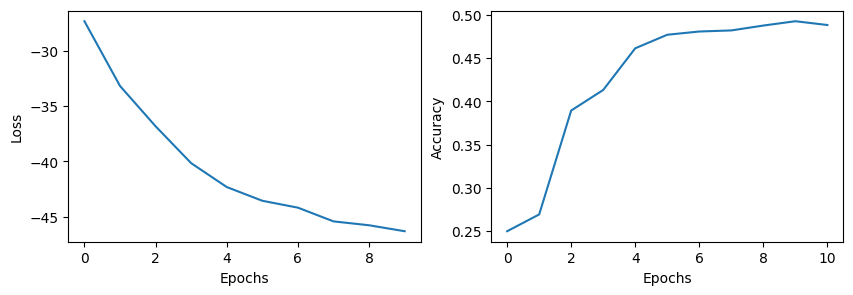

In [99]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [104]:
class MyNewNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 8, 5)
        self.conv2 = torch.nn.Conv2d(8, 16, 5)
        self.conv3 = torch.nn.Conv2d(16, 32, 5)
        self.dense = torch.nn.Linear(32*116*116, 4)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        # print(x.shape)
        x = x.view(-1, 32*116*116)
        x = self.softmax(self.dense(x))
        return x

In [105]:
model = MyNewNet().to(device)
y = model(torch.zeros( (3,128,128), device=device ))
print(y)

opt = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.NLLLoss()

num_epoch = 10
losses = []
accuracies = [0.25]

tensor([[0.2492, 0.2546, 0.2478, 0.2484]], grad_fn=<SoftmaxBackward0>)


In [106]:
for epoch in range(1, num_epoch+1):
    running_loss = 0.0
    correct_class = 0
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
        num_outputs = outputs.argmax(axis=1)
        correct_class += (num_outputs==labels).sum().item()
    accuracy_epoch = correct_class/len(train_data)
    accuracies.append(accuracy_epoch)
    losses.append(running_loss)
    print(f'Epoch [{epoch}/{num_epoch}]: Acc={accuracy_epoch:.4f} Loss={running_loss:.6f}')

Epoch [1/10]: Acc=0.2650 Loss=-25.957502
Epoch [2/10]: Acc=0.3644 Loss=-31.722498
Epoch [3/10]: Acc=0.4012 Loss=-36.509100
Epoch [4/10]: Acc=0.4719 Loss=-41.835233
Epoch [5/10]: Acc=0.5475 Loss=-47.775364
Epoch [6/10]: Acc=0.5463 Loss=-50.001022
Epoch [7/10]: Acc=0.5481 Loss=-51.538736
Epoch [8/10]: Acc=0.5469 Loss=-52.014100
Epoch [9/10]: Acc=0.5644 Loss=-53.262672
Epoch [10/10]: Acc=0.5713 Loss=-54.016295


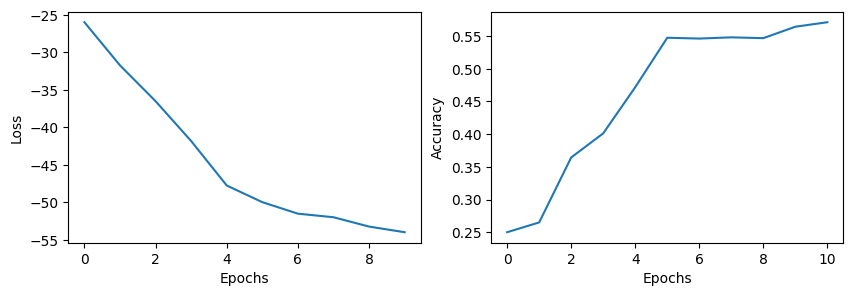

In [107]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()